In [2]:
import numpy as np
import pandas as pd

In [ ]:
https://www.kaggle.com/datasets/shubh0799/churn-modelling

In [3]:
df = pd.read_csv('archive_churn_modelling/Churn_Modelling.csv')

# ДЕЛЕНИЕ НА ВЫБОРКИ

In [4]:
from sklearn.model_selection import train_test_split

# чтобы избегать неравносмерности доли целевого параметра нужно задавать startify

train, test = train_test_split(df, train_size = 0.6, random_state = 42, stratify = df['Exited'])

In [5]:
val, test = train_test_split(test, train_size = 0.5, random_state = 42, stratify = test['Exited'])

# ЧЕЛОВЕЧЕСКОЕ ОБУЧЕНИЕ НА ДВУХ ФИЧАХ

In [6]:
# в человеческом обучении val не нужен, поэтому соединяем с train чтобы данных было больше
train_val = pd.concat([train, val])

In [7]:
train_val.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6851,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0
7026,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0
5705,5706,15698703,Doherty,628,Germany,Male,40,5,181768.32,2,1,1,129107.97,0


In [8]:
# так как Age переменная непрерывная - делим ее на группы:
train_val['age_group'] = pd.cut(train_val['Age'], [0, 31, 35, 40, 46, 99])

In [9]:
# получаем модель
model = train_val.groupby(['NumOfProducts', 'age_group'])['Exited'].agg('mean').reset_index()
model

,NumOfProducts,age_group,Exited
0,1,"(0, 31]",0.106774
1,1,"(31, 35]",0.135908
2,1,"(35, 40]",0.198646
3,1,"(40, 46]",0.378873
4,1,"(46, 99]",0.542506
5,2,"(0, 31]",0.029293
6,2,"(31, 35]",0.031206
7,2,"(35, 40]",0.059977
8,2,"(40, 46]",0.106239
9,2,"(46, 99]",0.225869


In [10]:
# Переименовываем колонки, чтобы не было повторных названий типо Exited_x, Exited_y
model.columns = ['NumOfProducts', 'age_group', 'score_prod_age']

In [11]:
model

,NumOfProducts,age_group,score_prod_age
0,1,"(0, 31]",0.106774
1,1,"(31, 35]",0.135908
2,1,"(35, 40]",0.198646
3,1,"(40, 46]",0.378873
4,1,"(46, 99]",0.542506
5,2,"(0, 31]",0.029293
6,2,"(31, 35]",0.031206
7,2,"(35, 40]",0.059977
8,2,"(40, 46]",0.106239
9,2,"(46, 99]",0.225869


In [12]:
# Мёржим модель к train_val

train_val = pd.merge(train_val, model, how = 'left', on = ['NumOfProducts', 'age_group'])

In [13]:
train_val.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age
0,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0,"(35, 40]",0.059977
1,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0,"(0, 31]",0.029293
2,5706,15698703,Doherty,628,Germany,Male,40,5,181768.32,2,1,1,129107.97,0,"(35, 40]",0.059977


In [14]:
# Считаем метрику log_loss:
    
from sklearn.metrics import log_loss

# теперь ошибка log_loss для модели с двумя параметрами:
print(log_loss(train_val['Exited'], train_val['score_prod_age']))

0.3866695862492173


In [15]:
# Функция для uplift:

# функция принмает df, определенный столбец со SCORE и pct - это сколько процентов выборки мы берем:
def uplift(df, score, pct):
    # посчитаем сколько всего в выборке отточных клиентов:
    exited_all = df['Exited'].sum()
    
    # отсортируем df по SCORE:
    df_sorted = df.sort_values(by = score, ascending = False)
    
    
    # теперь надо взять топ-20% этой отсортированной выборки:

    # получаем количество записей которые будут соответствовать pct % всей выборки:
    sorted_20 = round(len(df) * pct)
    
    # посчитаем сколько отточников нашлось в этих сортированных по score_prod строках:
    exited_found = df_sorted.head(sorted_20)['Exited'].sum()
    
    return (exited_found / exited_all) / pct 

In [16]:
# Считаем метрику uplift:

uplift(train_val, 'score_prod_age', 0.2)

2.684049079754601

In [17]:
# проверка модели на тесте:

# Добавляем к test age_group:
test['age_group'] = pd.cut(test['Age'], [0, 31, 35, 40, 46, 99])

# Мёржим модель к test:
test = pd.merge(test, model, how = 'left', on = ['NumOfProducts', 'age_group'])

In [18]:
# Считаем метрику log_loss на тесте:
    
from sklearn.metrics import log_loss

# теперь ошибка log_loss для модели с двумя параметрами:
print(log_loss(test['Exited'], test['score_prod_age']))

0.3870707514157596


In [19]:
# Считаем метрику uplift на тесте:

uplift(test, 'score_prod_age', 0.2)

2.7518427518427515

# МАШИННОЕ ОБУЧЕНИЕ НА ДВУХ ФИЧАХ

In [24]:
from catboost import CatBoostClassifier

In [55]:
# обучимся на тех фичах, на которых делали человеческое обучение:

X = ['NumOfProducts', 'Age']
y = ['Exited']
# не задаем список категориальных фичей, потому что все выбранные фичи - числовые.

In [56]:
# создаем параметры: 'learning_rate': сначала не задавали, потом 0.03, потом - 0.01 (добиваемся конечной итерации ближе к 998)

params = {'verbose':100,
         'random_seed': 42,
         'learning_rate': 0.01}

In [59]:
# создаем модель с этими параметрами:

model_1 = CatBoostClassifier(**params)

In [61]:
# запускаем обучение:

model_1.fit(train[X], train[y], eval_set = (val[X], val[y]))

0:	learn: 0.6853477	test: 0.6855086	best: 0.6855086 (0)	total: 145ms	remaining: 2m 25s
100:	learn: 0.4128869	test: 0.4105421	best: 0.4105421 (100)	total: 355ms	remaining: 3.16s
200:	learn: 0.3835957	test: 0.3780931	best: 0.3780931 (200)	total: 550ms	remaining: 2.19s
300:	learn: 0.3780929	test: 0.3709267	best: 0.3709267 (300)	total: 745ms	remaining: 1.73s
400:	learn: 0.3765599	test: 0.3689138	best: 0.3689138 (400)	total: 957ms	remaining: 1.43s
500:	learn: 0.3758081	test: 0.3679196	best: 0.3679196 (500)	total: 1.15s	remaining: 1.14s
600:	learn: 0.3753557	test: 0.3674833	best: 0.3674827 (599)	total: 1.34s	remaining: 889ms
700:	learn: 0.3749021	test: 0.3672342	best: 0.3672338 (696)	total: 1.53s	remaining: 654ms
800:	learn: 0.3744683	test: 0.3670441	best: 0.3670390 (799)	total: 1.72s	remaining: 428ms
900:	learn: 0.3739802	test: 0.3667761	best: 0.3667761 (900)	total: 1.91s	remaining: 210ms
999:	learn: 0.3733406	test: 0.3666605	best: 0.3666506 (979)	total: 2.1s	remaining: 0us

bestTest = 0.36

In [68]:
# проверка модели на тесте:

# при помощи model.predict_proba() - получаем две колонки SCORE - скор на то что чел останется, скор на то что чел уйдет:
# в сумме эти скоры для каждого человека равны 1

model_1.predict_proba(test[X])

array([[0.90204985, 0.09795015],
       [0.87651511, 0.12348489],
       [0.80322442, 0.19677558],
       ...,
       [0.87582238, 0.12417762],
       [0.94813726, 0.05186274],
       [0.94339253, 0.05660747]])

In [69]:
# в данном случае нам нужен скор только на отток (Exited):

model_1.predict_proba(test[X])[:, 1]

array([0.09795015, 0.12348489, 0.19677558, ..., 0.12417762, 0.05186274,
       0.05660747])

In [75]:
# добавим колонку со SCORE на отток в тестовую выборку:

test['machine_prod_age'] = model_1.predict_proba(test[X])[:, 1]

In [71]:
# еще добавим BaseLine - среднее значение по тестовой выборке: для общего сравнения всех подходов:
test['Baseline'] = test['Exited'].mean()

In [76]:
test.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,machine_prod_age,Baseline
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0, 31]",0.106774,0.097950,0.2035
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31, 35]",0.135908,0.123485,0.2035
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35, 40]",0.198646,0.196776,0.2035


# МАШИННОЕ ОБУЧЕНИЕ НА ВСЕХ ФИЧАХ

In [20]:
# обучимся на ВСЕХ фичах:

X = ['CustomerId', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']
y = ['Exited']

# категориальные фичи = ['Geography', 'Gender']
cat_features = ['Geography', 'Gender']

In [21]:
# взяли кусок кода с pool c Tutorial: CatBoost Overview (https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview)

from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [22]:
# на тестовой выборке 'learning_rate': не задаем потому что не знаем какой он будет

params_2 = {'verbose':100,
         'random_seed': 42}

In [25]:
model_2 = CatBoostClassifier(**params_2)

In [26]:
# запускаем обучение:

# так мы запускали раньше:
# model_2.fit(train[X], train[y], eval_set = (val[X], val[y]))

# с использованием Pool для более чистого кода:
model_2.fit(train_data, eval_set = valid_data)

Learning rate set to 0.04933
0:	learn: 0.6535333	test: 0.6537816	best: 0.6537816 (0)	total: 192ms	remaining: 3m 11s
100:	learn: 0.3121251	test: 0.3227529	best: 0.3227529 (100)	total: 2.87s	remaining: 25.5s
200:	learn: 0.2825968	test: 0.3200314	best: 0.3191361 (160)	total: 5.57s	remaining: 22.1s
300:	learn: 0.2540340	test: 0.3217938	best: 0.3191361 (160)	total: 8.06s	remaining: 18.7s
400:	learn: 0.2320413	test: 0.3250301	best: 0.3191361 (160)	total: 10.7s	remaining: 16s
500:	learn: 0.2140452	test: 0.3277914	best: 0.3191361 (160)	total: 13.3s	remaining: 13.3s
600:	learn: 0.1971038	test: 0.3314336	best: 0.3191361 (160)	total: 16s	remaining: 10.6s
700:	learn: 0.1829112	test: 0.3336272	best: 0.3191361 (160)	total: 18.4s	remaining: 7.86s
800:	learn: 0.1697085	test: 0.3364924	best: 0.3191361 (160)	total: 20.9s	remaining: 5.19s
900:	learn: 0.1570039	test: 0.3413958	best: 0.3191361 (160)	total: 23.5s	remaining: 2.58s
999:	learn: 0.1462497	test: 0.3446710	best: 0.3191361 (160)	total: 26s	remaini

In [27]:
# Для проверки модели на тесте:

test['SCORE_ALL_FEATURES'] = model_2.predict_proba(test[X])[:, 1]

In [31]:
# еще добавим BaseLine - среднее значение по тестовой выборке: для общего сравнения всех подходов:
test['Baseline'] = test['Exited'].mean()

In [28]:
test.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,SCORE_ALL_FEATURES
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0, 31]",0.106774,0.117387
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31, 35]",0.135908,0.069690
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35, 40]",0.198646,0.169110


### Метрика log_loss Проверка всех подходов:

In [33]:
from sklearn.metrics import log_loss

# ошибка log_loss для среднего mean('Exited'):
print('Baseline: ', log_loss(test['Exited'], test['Baseline']))


# ошибка log_loss для модели человеческого обучения:
print('Человеческое обучение: ', log_loss(test['Exited'], test['score_prod_age']))

# ошибка log_loss для модели_1:
print('Машинное обучение на двух фичах: ',  log_loss(test['Exited'], test['machine_prod_age']))

# ошибка log_loss для модели_2:
print('Машинное обучение на ВСЕХ фичах: ',  log_loss(test['Exited'], test['SCORE_ALL_FEATURES']))

Baseline:  0.5052163384611609
Человеческое обучение:  0.3870707514157596
Машинное обучение на ВСЕХ фичах:  0.3288130105042308


### Метрика uplift (функция задана выше) Проверка всех подходов:

In [35]:
# Считаем метрику uplift на тесте:

print('Baseline: ', uplift(test, 'Baseline', 0.2))
print('Человеческое обучение: ', uplift(test, 'score_prod_age', 0.2))
print('Машинное обучение на двух фичах: ', uplift(test, 'machine_prod_age', 0.2))
print('Машинное обучение на ВСЕХ фичах: ', uplift(test, 'SCORE_ALL_FEATURES', 0.2))

Baseline:  1.0442260442260443
Человеческое обучение:  2.7518427518427515
Машинное обучение на ВСЕХ фичах:  3.1326781326781328


# СКОР И ПОРОГИ

In [ ]:
# Скорs: 'Baseline', 'score_prod_age', 'machine_prod_age', 'SCORE_ALL_FEATURES'

# что такое скор - это то, что выходит из модели калссификации

# это оценка, которая показывает склонность в данном случае человека к оттоку

# чем больше этот скор, тем больше человек склонен к оттоку
# чем меньше этот скор, тем меньше человек склонен к оттоку

# также иногда этот скор может являться вероятностью, но не всегда это так:
    
# Скор можно интерпретировать, как вероятность, когда он 
# соответствует фактической вероятности, и это можно 
# проверить. Можно взять и разбить скор на бины:
# 0-0.1, 0.1-0.2, 0.2-0.3 ... 0.9-1 и посчитать 
# для этих бинов среднее по таргету: это среднее 
# должно соответствовать среднему по этому 
# бину, т.е. для 0-0.1 это (0.1-0)/2 = 0.05. 
# Подробнее про это можно почитать в статьях 
# про калибровку моделей, например вот 
# https://towardsdatascience.com/classifier-calibration-7d0be1e05452 . 
# Есть и на русском, но там чето слишком замудренно) 
# https://stepik.org/lesson/683315/step/2?unit=682138 - в комментариях ссылка
    
Скор всегда нормированный - он всегда будет от 0 до 1

КАК ИЗ СКОРА ПОЛУЧИТЬ КЛАСС - КАК ПРИНЯТЬ РЕШЕНИЕ - ОТТОЧНЫЙ КЛИЕНТ ИЛИ НЕ ОТТОЧНЫЙ??
это решение можно принять с помощью порогов например score > 0.5
Таким образом скор можно преобразовать в конкретный класс - в конкретное решение.


<Axes: >

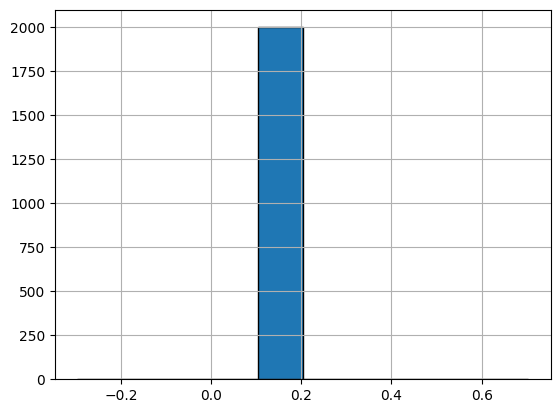

In [94]:
# посмотрим на распределение скора для Baseline:

test['Baseline'].hist(edgecolor = 'black')   

<Axes: >

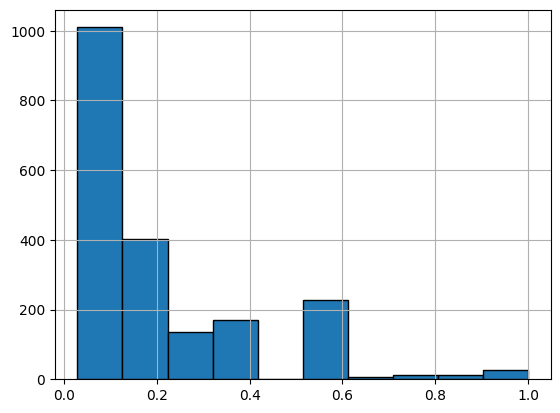

In [91]:
# посмотрим на распределение скора в человеческом обучении:

test['score_prod_age'].hist(edgecolor = 'black')   


<Axes: >

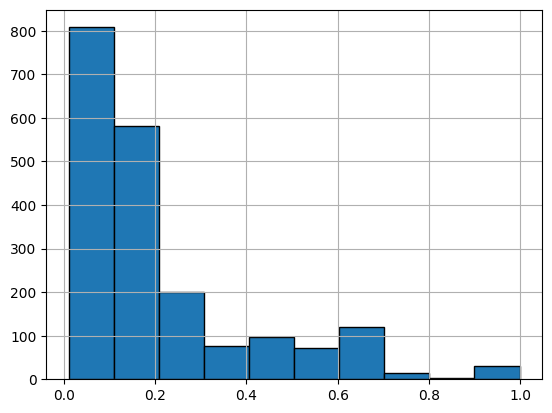

In [92]:
# посмотрим на распределение скора в машинном обучении для двух фичей:

test['machine_prod_age'].hist(edgecolor = 'black') 

<Axes: >

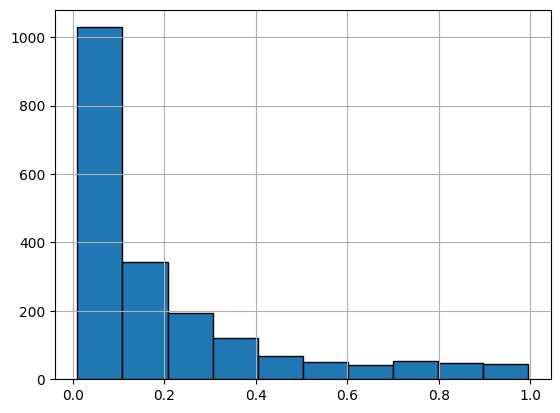

In [93]:
# посмотрим на распределение скора в машинном обучении для ВСЕХ фичей:

test['SCORE_ALL_FEATURES'].hist(edgecolor = 'black')

# PREDICT y_pred

In [36]:
# Предикт y_pred - с установленным порогом:

test['y_pred'] = test['SCORE_ALL_FEATURES'] > 0.5

In [37]:
# умножая bool на 1 получаем 1 или 0
print(True * 1, False * 1)

1 0


In [38]:
# чтобы в столбце test['y_pred'] значения были представлены не как "True и False", а как "0 и 1":
    
test['y_pred'] = (test['SCORE_ALL_FEATURES'] > 0.5)*1

In [39]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,SCORE_ALL_FEATURES,Baseline,y_pred
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0, 31]",0.106774,0.117387,0.2035,0
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31, 35]",0.135908,0.069690,0.2035,0
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35, 40]",0.198646,0.169110,0.2035,0
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31, 35]",0.135908,0.089905,0.2035,0
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31, 35]",0.135908,0.062131,0.2035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46, 99]",0.225869,0.026964,0.2035,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35, 40]",0.198646,0.102691,0.2035,0
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40, 46]",0.106239,0.176148,0.2035,0
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35, 40]",0.059977,0.066283,0.2035,0


In [40]:
# Теперь можно посчитать только еденицы - долю тех, кому мы предсказали отток:

test['y_pred'].mean()

0.121

In [ ]:
# теперь нужно научиться анализировать этот ответ:

# МАТРИЦА ОШИБОК

In [ ]:
# матрица ошибок - главная вещь для анализа ответа классификатора

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
pd.DataFrame(confusion_matrix(test['Exited'], test['y_pred']))

,0,1
0,1539,54
1,219,188


In [43]:
tn, fp, fn, tp = confusion_matrix(test['Exited'], test['y_pred']).ravel()

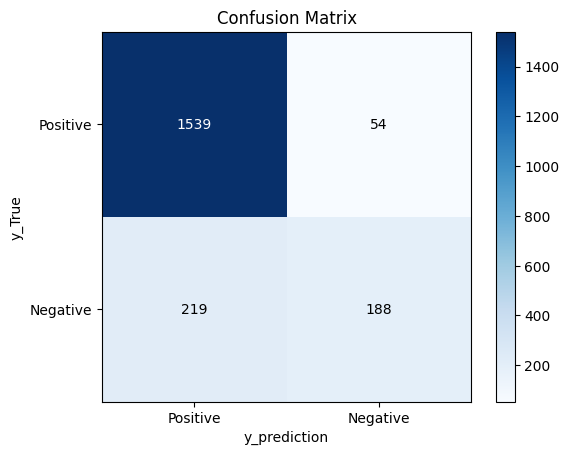

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(test['Exited'], test['y_pred']).ravel()

# Создание матрицы ошибок
confusion_matrix = np.array([[tn, fp], [fn, tp]])

# Настройка осей
classes = ['Positive', 'Negative']
ticks = np.arange(len(classes))

# Создание графика
plt.imshow(confusion_matrix, cmap='Blues')

# Добавление текста к ячейкам
thresh = confusion_matrix.max() / 2
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

# Настройка осей и заголовка
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
plt.xlabel('y_prediction')
plt.ylabel('y_True')
plt.title('Confusion Matrix')

# Отображение цветовой шкалы
plt.colorbar()

# Показать график
plt.show()

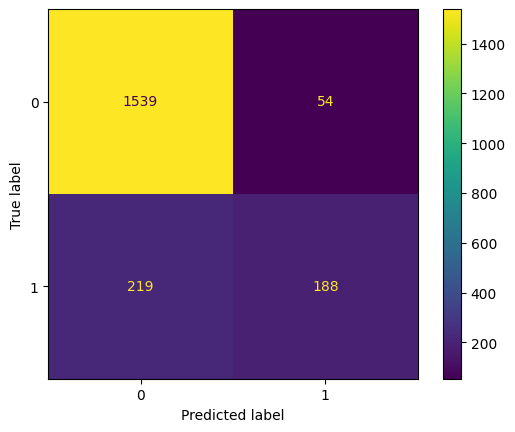

In [130]:
from sklearn.metrics import ConfusionMatrixDisplay
confmetrx = ConfusionMatrixDisplay(confusion_matrix(test['Exited'], test['y_pred']))
confmetrx.plot()

In [ ]:
#     Если y_True и y_prediction совпадают - значит TRUE
    
#     Если y_True и y_prediction НЕ совпадают - значит FALSE


# Чтобы определить POSITIVE или NEGATIVE смотрим на y_prediction:

#     Если TRUE:
# Если y_prediction = Positive и y_True = Positive - значит TRUE POSITIVE
# Если y_prediction = Negative и y_True = Negative - значит TRUE NEGATIVE

#     Если FALSE:
# Если y_prediction = Positive и y_True = Negative - значит FALSE POSITIVE - ложное срабатываение - ошибка I рода
# Если y_prediction = Negative и y_True = Positive - значит TRUE NEGATIVE - ложный пропуск - ошибка II рода

# Все основные метрики считаются на основе матрицы ошибок confusion_matrix

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

## Recall (полнота)
sensitivity, recall, hit rate, or true positive rate (TPR)

In [ ]:
# Recall - это процент 'единичек', которые модель пометила как 'единички'

# Эта метрика показывает насколько хорошо эта метрика умеет подсвечивать 'единички'

# В случае оттока клиентов - насколько хорошо она может подсветить отточного клиента

# Случае с сигналом - насколько хорошо она может подсвечивать сигнал

# tn, fp, fn, tp
# Формула: TPR = tp / P = tp / (tp + fn)

# !!! ПОКАЗЫВАЕТ ПРОЦЕНТ ВСЕХ НАСТОЯЩИХ ЕДИНИЧЕК, ПОМЕЧЕННЫХ ЕДИНИЧКАМИ - рассматриваем все единицы из y_TRUE

In [51]:
recall = tp / (tp + fn)
recall

0.4619164619164619

In [47]:
# или по-другому:

from sklearn.metrics import recall_score

recall_score(test['Exited'], test['y_pred'])

0.4619164619164619

In [ ]:
# одного recall недостаточно для оценки качества модели

## Precision (точность)

In [ ]:
Precision - показывает процент правильных 'единичек', среди всех предсказанных 'единичек'

# !!! ПОКАЗЫВАЕТ ПРОЦЕНТ ВСЕХ ПРЕДСКАЗАННЫХ ЕДИНИЧЕК - рассматриваем все единицы из y_pred

In [49]:
precision = tp/(tp + fp)
precision

0.7768595041322314

In [50]:
# или по-другому:

from sklearn.metrics import precision_score

precision_score(test['Exited'], test['y_pred'])

0.7768595041322314

In [ ]:
# Precision у этой модели лучше чем Recall - это означает что:

# Проценты Precision говорят о том что такой процент из помеченных моделью как "1" будут действительно "1"

# Проценты Recall говорят о том что, такой процент из реальных "1" будут помечены моделью как "1"

### Пример Recall и Precision на кошках и ребенке

In [ ]:
Учим ребенка опредеялть животное. Если кошка - говорит "мяу", если не кошка - молчит.

Задача бинарной классификации, ребенок - модель, классификатор.

Recall

Показали 100 картинок с кошкой. Только 80 сказал "мяу". Recall == 80/100 == 0.8 == 80%


Precision

Показываем 100 картинок не только с кошкой, но и с другими животными.

Сказано "мяу" 50 раз. Взяли эти 50 картинок на которые сказано "мяу" и оказалось что только на 20 из них есть кошка.

Значит Precision ребенка 20/50 == 0.4 == 40% 

Значит из тех 50 "Мяу" тоьлко 40% оказались кошкой на самом деле.

In [ ]:
# С помощью двух этих метрик Recall и Precision уже можно оценивать работу классификатора

Одного Recall недостаточно, также как и одного Precision.

Но с помощью этих двух метрик уже можно говорить на сколько хорошо решаются задачи классификатора.

## Метрика F1
Объединяет в себе Recall и Precision

In [53]:
f1 = (2 * recall * precision) / (recall + precision)
f1

0.5793528505392913

In [ ]:
# метрика f1 - находится в диапазоне от 0 до 1 и чем больше, тем лучше.

In [54]:
from sklearn.metrics import f1_score

f1_score(test['Exited'], test['y_pred'])

0.5793528505392913

In [ ]:
# Общая функция sklearn для расчета любого f-score:

from sklearn.metrics import fbeta_score
 
fbeta_score(test['Exited'], test['y_pred'], beta=1)   # f1-score
 

# Под капотом:

b = 1

((1 + b**2) * precision * recall) / (b**2 * precision + recall)

In [ ]:
# f1 - является частным случаем F-метрики (F-Score)

https://en.wikipedia.org/wiki/F-score
    
# F1 показывает нам насколько Recall важнее чем Precision

# 1 это вес, он может быть и другим (1 - это значение коэфф.бета в формуле F-Score)
# когда бета == 1 это значит Recall и Precision одинаково значимы для нас


# В зависимости от конкретной безнес задачи выставляется 2 (Recall важнее для нас чем precision) или 0.5 (Наоборот)



### КОГДА НАМ ВАЖЕН Recall ???

Мы хотим сбивать все корабли пришельцев, но это также могут быть астеройды.
Нам неважно сколько мы собъем астеройдов, главное чтобы были сбиты все корабли.
Важно чтобы ни один корабль не прошел.
Не важно сколько при этом уничтожено астеройдов.

### КОГДА НАМ ВАЖЕН Precision ???

Мы должны назначить очень опасную операцию, и нам надо убедиться что она действительно необходима.
Нам важно точно поставить диагноз.
Поскольку операция опасная - нельзя отправлять всех пациентов на операционный стол без разбора.
Нам важно чтобы на операцию попадали только те, кто точно в ней нуждается.
Нам важен Precision




# Метрика Accuracy
Процент правильных ответов

In [55]:
# там где модель назначила правильный класс - будет True, там где - не правильный - будет False:

test['Exited'] == test['y_pred']

0        True
1        True
2        True
3        True
4        True
        ...  
1995     True
1996     True
1997    False
1998     True
1999     True
Length: 2000, dtype: bool

In [58]:
# чтобы понять процент правильных ответов - Accuracy:

(test['Exited'] == test['y_pred']).mean()

0.8635

In [60]:
# или с помощью матрицы ошибок:

(tn + tp) / (tn + tp + fn + fp)

0.8635

In [62]:
# или с помощью sklearn:

from sklearn.metrics import accuracy_score

accuracy_score(test['Exited'], test['y_pred'])

0.8635

In [63]:
# нули и единицы распределены по выборке не 50% на 50%:

# доля единиц в нашем случае 20%, доля нулей 80%

# это не сбалансированный класс:

test['Exited'].mean()

# ЭТУ МЕТРИКУ НЕЛЬЗЯ ИСПОЛЬЗОВАТЬ КОГДА У НАС НЕ СБАЛАНСИРОВАННЫЕ КЛАССЫ

0.2035

# Classification report

In [65]:
from sklearn.metrics import classification_report

In [67]:
print(classification_report(test['Exited'], test['y_pred']))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.78      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000



In [69]:
# выше мы считали для класса еденичек:

print(recall)
print(precision)
print(f1)

0.4619164619164619
0.7768595041322314
0.5793528505392913
